<a href="https://colab.research.google.com/github/weasel-codes/email-spam/blob/main/Unsupervised_feature_learning_for_spam_email_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised feature learning for spam email filtering

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt
import os

# Dataset Import

## Email

### Dataset Insight

In [51]:
df = pd.read_csv("/content/drive/MyDrive/ML/email-filtering/eron_email_96.csv")
print("email dataset shape : ", df.shape)
df.head()

email dataset shape :  (37308, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [52]:
print(df.loc[0]['message'])
message = df.loc[2]['message']
e = email.message_from_string(message)
print("######## \nEmail in json format resembling csv and column wise data : \n" , e.items())
print("printing al the keys in message : \n" , e.keys())

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 
######## 
Email in json format resembling csv and column wise data : 
 [('Message-ID', '<24216240.1075855687451.JavaMail.evans@thyme>'), ('Date', 'Wed, 18 Oct 2000 03:00:00 -0700 (PDT)'), ('From', 'phillip.allen@enron.com'), ('To', 'leah.arsdall@enron.com'), ('Subject', 'Re: test'), ('Mime-Version', '1.0'), ('Content-Type', 'text/plain; charset=us-ascii'), ('Content-Transfer-Encoding', '7bit'), ('X-From', 'Phillip K Allen'), ('X-To', 'Leah Van Arsdall'), ('X-cc', ''), ('X-bcc', ''), ('X-Folder', "\\Phi

### Generating required columns

In [53]:
# fetching only required columns
def body(d):
    message = df['message']
    column = []
    frm = []
    sub = []
    emp = []

    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
        frm.append(e.get('From'))
        sub.append(e.get('Subject'))

    f = df['file']
    for string in f:
      emp.append(string.split("/")[0])

    return column, frm, sub, emp

df['body'], df['from'], df['subject'], df['emp'] = body(df)
df.head(3)

,file,message,body,from,subject,emp
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,phillip.allen@enron.com,,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p


### Deleted not required columns

In [54]:
df.head()

,file,message,body,from,subject,emp
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,phillip.allen@enron.com,,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",phillip.allen@enron.com,,allen-p
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,Re: Hello,allen-p


In [55]:
df.drop(labels = ['file','message'], axis=1, inplace=True)
df.head()

,body,from,subject,emp
0,Here is our forecast\n\n,phillip.allen@enron.com,,allen-p
1,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
2,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p
3,"Randy,\n\n Can you send me a schedule of the s...",phillip.allen@enron.com,,allen-p
4,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,Re: Hello,allen-p


### Replace empty missing values in subject with np.nan

In [56]:
df.isnull().sum(), df.shape

(body       0
 from       0
 subject    0
 emp        0
 dtype: int64, (37308, 4))

In [57]:
def replace_empty_with_nan(subject):
    column = []
    for val in subject:
        if (val == ""):
            column.append(np.nan) 
        else:
            column.append(val)
    return column
df['subject'] = replace_empty_with_nan(df['subject'])

### Check for isnull

In [58]:
# drop missing value rows
df.dropna(axis=0, inplace=True)
df.isnull().sum(), df.shape

(body       0
 from       0
 subject    0
 emp        0
 dtype: int64, (34553, 4))

### Top 10 email sender

SELECT

In [62]:
top_10 = pd.DataFrame(df['emp'].value_counts()[:10])
top_10.reset_index(inplace=True)
top_10.columns = ["emp", "count"]
top_10

,emp,count
0,beck-s,11693
1,bass-e,7229
2,arnold-j,3896
3,blair-l,3369
4,baughman-d,2700
5,allen-p,2174
6,badeer-r,868
7,brawner-s,760
8,benson-r,755
9,arora-h,634


VISUALIZE

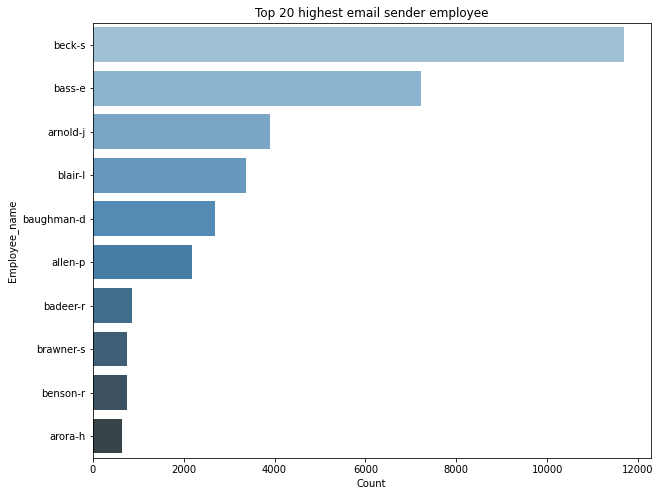

In [66]:
plt.figure(figsize=(10,8))
sns.barplot(y="emp", x="count", data=top_10, palette="Blues_d")
plt.title("Top 20 highest email sender employee")
plt.xlabel("Count")
plt.ylabel("Employee_name")
plt.show()



In [67]:
# save the data
df.to_csv("/content/drive/MyDrive/ML/email-filtering/enron_email_96_cleaned_data.csv", index=False)

## IMDB Review

In [ ]:
arry = []
file_name = []
# iterate through all file 
for file in os.listdir("/content/drive/MyDrive/ML/email-filtering/imdb_unsup"): 
    # Check whether file is in text format or not 
    if file.endswith(".txt"): 
        file_path = f"/content/drive/MyDrive/ML/email-filtering/imdb_unsup/{file}"
        # call read text file function 
        # read_text_file(file_path) 
        f = open(file_path, "r")
        arry.append(f.readlines())
        file_name.append(f.name)

imdb = [arry, file_name]
print(imdb)